In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import torch
print(torch.__version__)

1.12.1+cu113


In [27]:
!python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.12/index.html
#exit(0) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-5z_ccij5
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-5z_ccij5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.12/index.html


In [28]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

In [29]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [ ]:
register_coco_instances("logos", {},
                        "/content/drive/MyDrive/Sponsorlytix/data/trainval.json",
                        "/content/drive/MyDrive/Sponsorlytix/data/images")



In [ ]:
logos_metadata = MetadataCatalog.get("logos")
dataset_dicts = DatasetCatalog.get("logos")

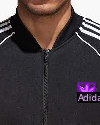

In [34]:
import random

for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=logos_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [35]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("logos",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2  
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 300  
cfg.SOLVER.STEPS = []       
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[09/28 09:00:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[09/28 09:00:48 d2.engine.train_loop]: Starting training from iteration 0
[09/28 09:00:57 d2.utils.events]:  eta: 0:01:53  iter: 19  total_loss: 2.734  loss_cls: 1.65  loss_box_reg: 0.3185  loss_mask: 0.692  loss_rpn_cls: 0.03749  loss_rpn_loc: 0.007343  time: 0.4172  data_time: 0.0277  lr: 1.6068e-05  max_mem: 3342M
[09/28 09:01:06 d2.utils.events]:  eta: 0:01:51  iter: 39  total_loss: 2.306  loss_cls: 1.216  loss_box_reg: 0.3564  loss_mask: 0.687  loss_rpn_cls: 0.04468  loss_rpn_loc: 0.006827  time: 0.4425  data_time: 0.0125  lr: 3.2718e-05  max_mem: 3432M
[09/28 09:01:15 d2.utils.events]:  eta: 0:01:38  iter: 59  total_loss: 1.644  loss_cls: 0.5998  loss_box_reg: 0.3115  loss_mask: 0.6742  loss_rpn_cls: 0.04219  loss_rpn_loc: 0.007801  time: 0.4335  data_time: 0.0093  lr: 4.9367e-05  max_mem: 3432M
[09/28 09:01:23 d2.utils.events]:  eta: 0:01:32  iter: 79  total_loss: 1.504  loss_cls: 0.4145  loss_box_reg: 0.3629  loss_mask: 0.6422  loss_rpn_cls: 0.05064  loss_rpn_loc: 0.008765  tim

In [36]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  
cfg.DATASETS.TEST = ("logos", )
predictor = DefaultPredictor(cfg)

[09/28 09:03:05 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

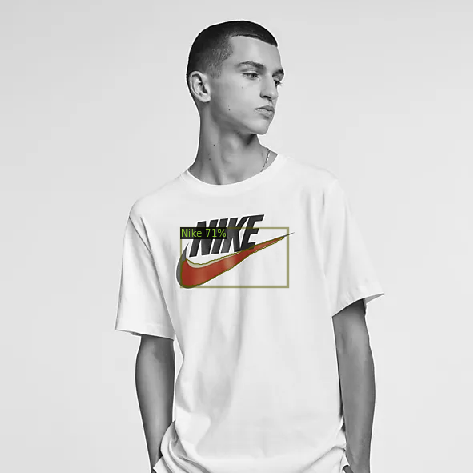

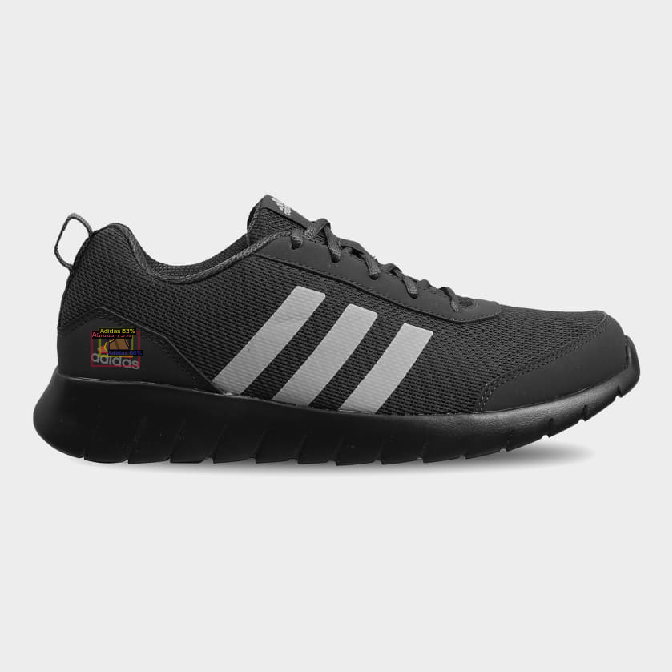

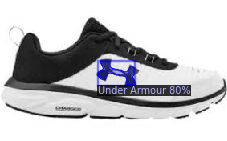

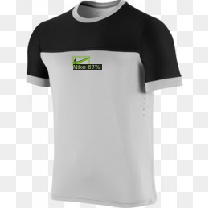

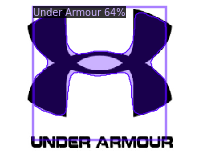

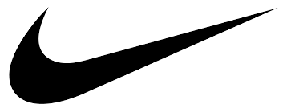

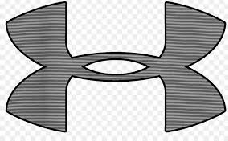

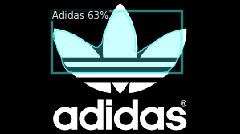

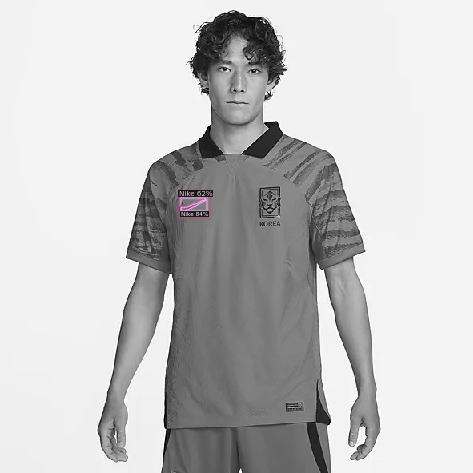

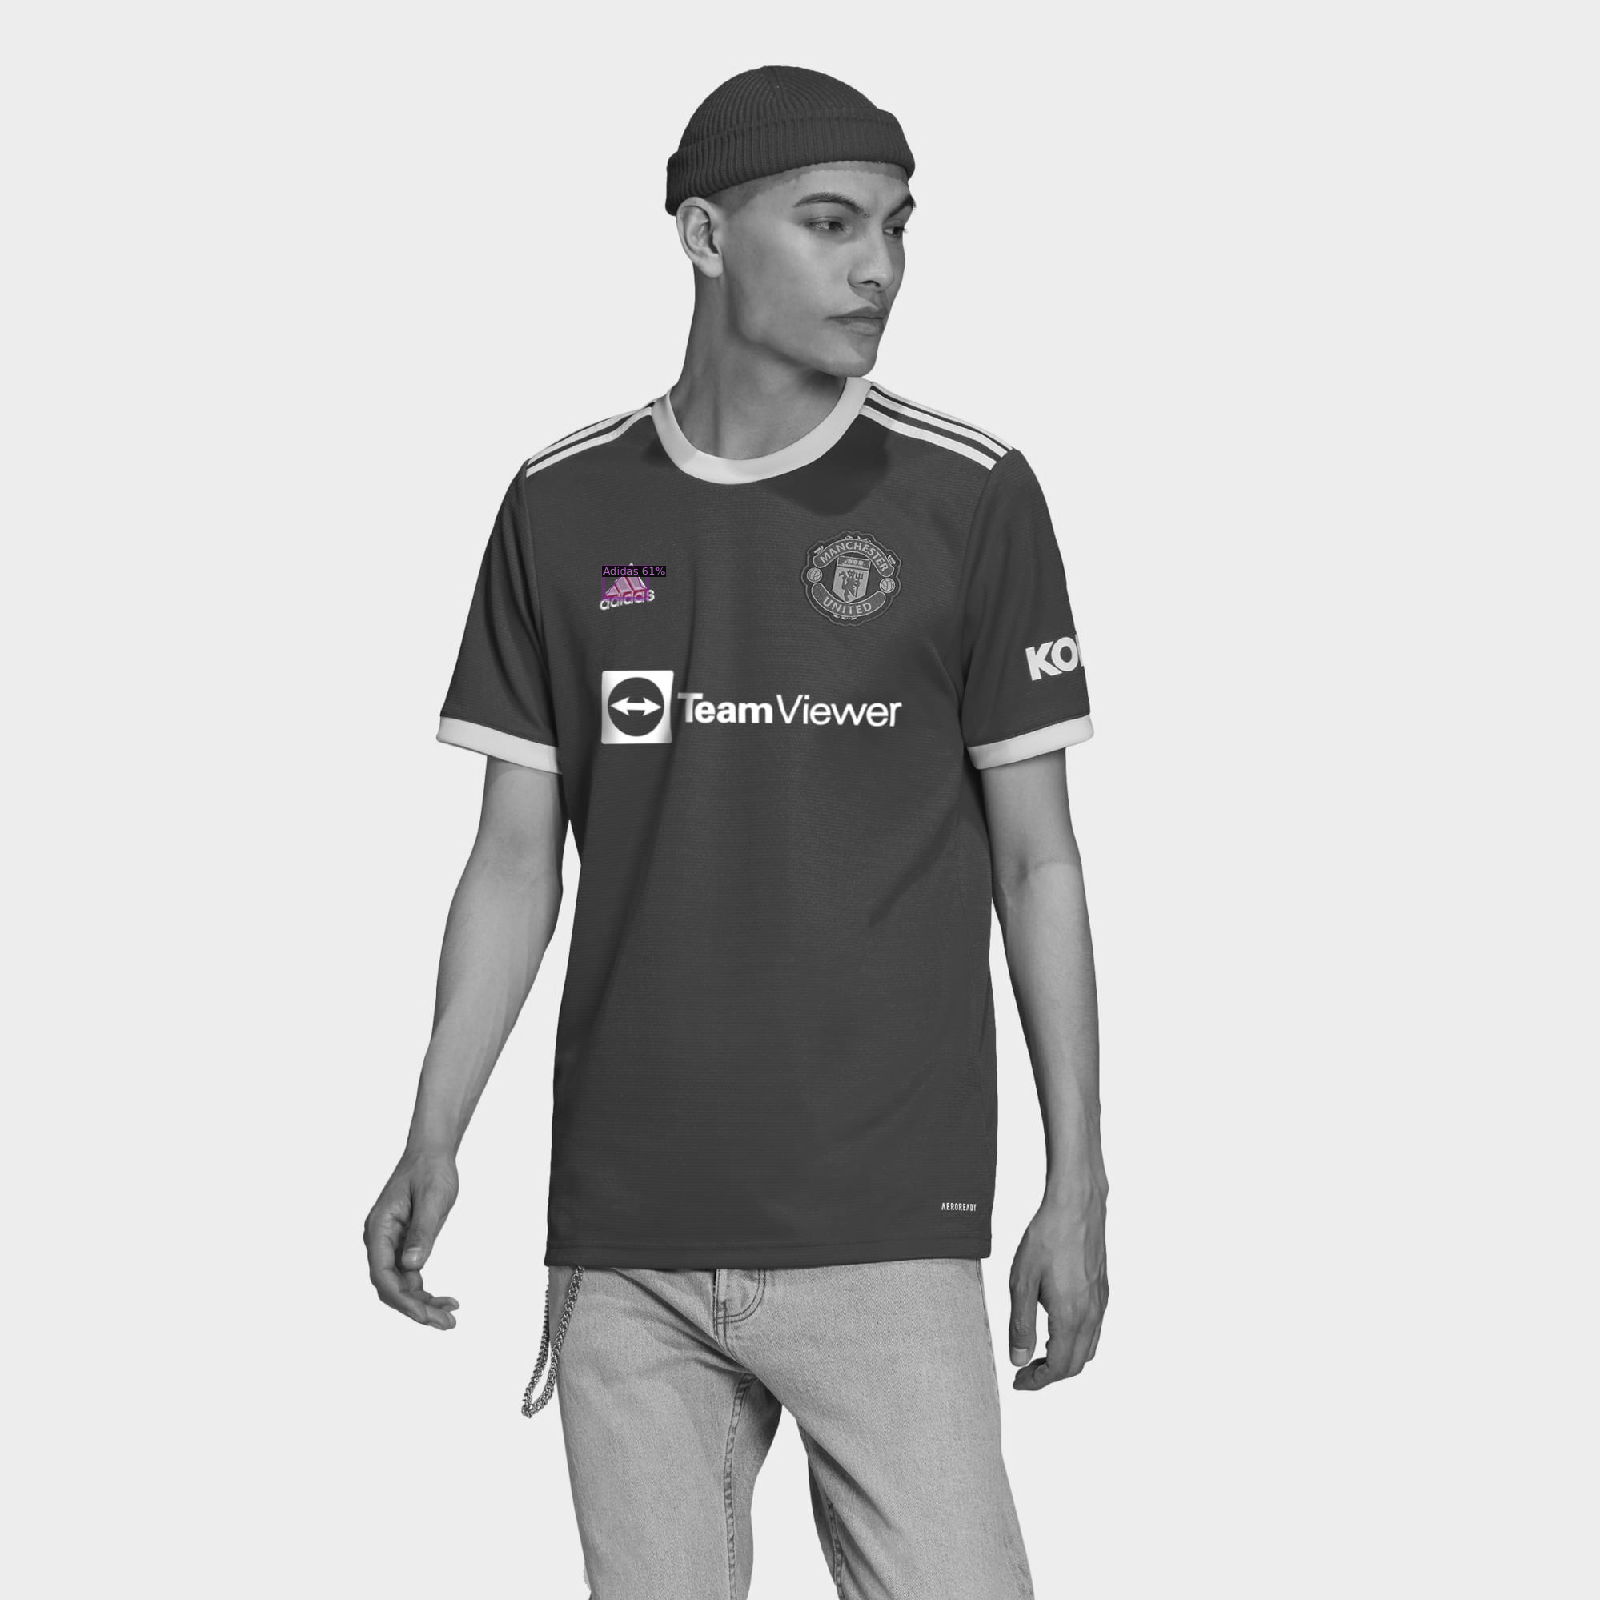

In [37]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=logos_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [38]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.11,fps:8.73


In [39]:
from detectron2.modeling import build_model
model = build_model(cfg) 

from detectron2.checkpoint import DetectionCheckpointer
DetectionCheckpointer(model).load("/content/output/model_final.pth")  

checkpointer = DetectionCheckpointer(model, save_dir="output")
checkpointer.save("model_ver1")  

[09/28 09:03:11 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [ ]:
pred = DefaultPredictor(cfg)
inputs = cv2.imread("/content/drive/MyDrive/Sponsorlytix/data/images/16.png")
outputs = pred(inputs)

[09/28 08:51:16 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

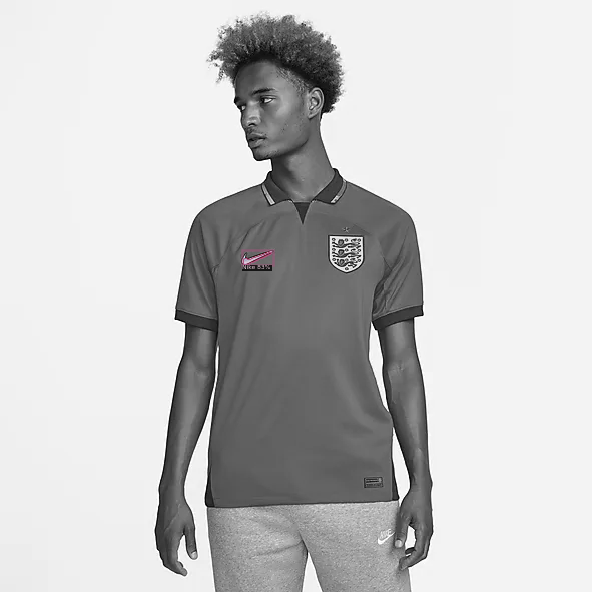

In [40]:
from detectron2.utils.visualizer import ColorMode
    
im = cv2.imread("/content/drive/MyDrive/Sponsorlytix/data/images/16.png")
outputs = pred(im)
v = Visualizer(im[:, :, ::-1],
                metadata=logos_metadata, 
                scale=1, 
                instance_mode=ColorMode.IMAGE_BW   
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

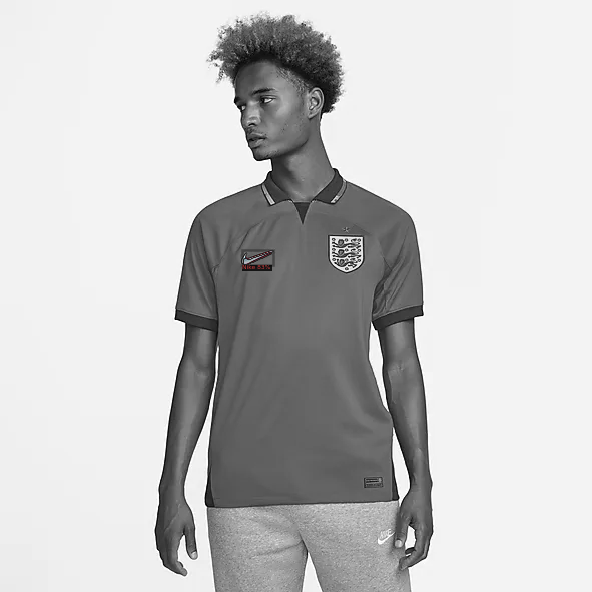

In [41]:
from detectron2.utils.visualizer import ColorMode
 
im = cv2.imread("/content/drive/MyDrive/Sponsorlytix/data/images/16.png")
outputs = pred(im)
v = Visualizer(im[:, :, ::-1],
                metadata=logos_metadata, 
                scale=1, 
                instance_mode=ColorMode.IMAGE_BW   
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])


In [42]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Sponsorlytix/video.mp4')
if (cap.isOpened()== False):
  print("Error opening video stream or file")
import cv2
import numpy as np
import glob
i = 0
frameSize = (500, 500)
out = cv2.VideoWriter('output_video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 24, frameSize)
while(cap.isOpened()):
  ret, frame = cap.read()
  if i>0:
    if ret == True:
      cv2.imwrite('kang.jpg',frame)
      im = cv2.imread("kang.jpg")
      outputs = pred(im)
      v = Visualizer(im[:, :, ::-1],
                      metadata=logos_metadata, 
                      scale=1, 
                      instance_mode=ColorMode.IMAGE_BW   
      )
      v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
      #cv2_imshow(v.get_image()[:, :, ::-1])
      out.write(cv2.resize(v.get_image()[:, :, ::-1], (500,500) ))
  if i==300:
   break
  i += 1

out.release()
cap.release()
cv2.destroyAllWindows()

In [43]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Sponsorlytix/adidas_input.mp4')
if (cap.isOpened()== False):
  print("Error opening video stream or file")
import cv2
import numpy as np
import glob
i = 0
frameSize = (500, 500)
out = cv2.VideoWriter('output_video_adidas2.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 24, frameSize)
while(cap.isOpened()):
  ret, frame = cap.read()
  if i > 0:
    if ret == True:
      cv2.imwrite('adidas.jpg',frame)
      im = cv2.imread("adidas.jpg")
      outputs = pred(im)
      v = Visualizer(im[:, :, ::-1],
                      metadata=logos_metadata, 
                      scale=1, 
                      instance_mode=ColorMode.IMAGE   
      )
      v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
      out.write(cv2.resize(v.get_image()[:, :, ::-1], (500,500) ))
  if i == 300:
   break
  i += 1

out.release()
cap.release()
cv2.destroyAllWindows()


In [44]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Sponsorlytix/video.mp4')
if (cap.isOpened()== False):
  print("Error opening video stream or file")
import cv2
import numpy as np
import glob
i = 0
frameSize = (500, 500)
out = cv2.VideoWriter('output_video_nike.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 24, frameSize)
while(cap.isOpened()):
  ret, frame = cap.read()
  if i > 0:
    if ret == True:
      cv2.imwrite('nike.jpg',frame)
      im = cv2.imread("nike.jpg")
      outputs = pred(im)
      v = Visualizer(im[:, :, ::-1],
                      metadata=logos_metadata, 
                      scale=1, 
                      instance_mode=ColorMode.IMAGE   
      )
      v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
      #cv2_imshow(v.get_image()[:, :, ::-1])
      out.write(cv2.resize(v.get_image()[:, :, ::-1], (500,500) ))
  if i == 600:
   break
  i += 1

out.release()
cap.release()
cv2.destroyAllWindows()


In [49]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Sponsorlytix/pp.mp4')
if (cap.isOpened()== False):
  print("Error opening video stream or file")
import cv2
import numpy as np
import glob
i = 0
frameSize = (500, 500)
out = cv2.VideoWriter('output_video_puma.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 24, frameSize)
while(cap.isOpened()):
  ret, frame = cap.read()
  if i > 0:
    if ret == True:
      cv2.imwrite('puma.jpg',frame)
      im = cv2.imread("puma.jpg")
      outputs = pred(im)
      v = Visualizer(im[:, :, ::-1],
                      metadata=logos_metadata, 
                      scale=1, 
                      instance_mode=ColorMode.IMAGE   
      )
      v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
      out.write(cv2.resize(v.get_image()[:, :, ::-1], (500,500) ))
  if i == 600:
   break
  i += 1

out.release()
cap.release()
cv2.destroyAllWindows()


In [46]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Sponsorlytix/underarmour_input.mp4')
if (cap.isOpened()== False):
  print("Error opening video stream or file")
import cv2
import numpy as np
import glob
i = 0
frameSize = (500, 500)
out = cv2.VideoWriter('output_video_underarmour.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 24, frameSize)
while(cap.isOpened()):
  ret, frame = cap.read()
  if i > 0:
    if ret == True:
      cv2.imwrite('underarmour.jpg',frame)
      im = cv2.imread("underarmour.jpg")
      outputs = pred(im)
      v = Visualizer(im[:, :, ::-1],
                      metadata=logos_metadata, 
                      scale=1, 
                      instance_mode=ColorMode.IMAGE   
      )
      v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
      out.write(cv2.resize(v.get_image()[:, :, ::-1], (500,500) ))
  if i == 600:
   break
  i += 1

out.release()
cap.release()
cv2.destroyAllWindows()


In [ ]:
# Download the results
from google.colab import files
files.download('/content/drive/MyDrive/ColabNotebooks/logos_dataset/video-output.mp4')